In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

In [0]:
# LeNet Model definition
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        
        return F.log_softmax(x, dim=1)

In [19]:
# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CUDA Available:  True


Of note: This notebook uses only a single GPU.
PyTorch can run models on several GPU, try to search how to specify several GPUs and create several devices.

In [20]:
model = Net().to(device)
model

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

## Master way

Or inspect code for training a model

In [0]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./mnist', 
                   download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                   ])),
    batch_size=128, shuffle=True)

In [0]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()

# Use Stochastic Gradient Descent
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [23]:
epoch_num = 20
for epoch in range(epoch_num):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()
        
        # Remember a line with model.to(device)?
        # It moves a model to a GPU and PyTorch expects that
        # input data also will be on the GPU where the model resides
        inputs, labels = inputs.to(device), labels.to(device)

        # forward + backward + optimize
        outputs = model(inputs)
        
        # Calculate the error between model predictins and actual labels
        loss = criterion(outputs, labels)
        
        # Initiate backward propagation
        loss.backward()
        
        # Update weights
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 200 == 199:    # print every 200 mini-batches
            print(f'[Epoch {epoch + 1}: batch {i + 1}] loss: {running_loss / 200}')
            running_loss = 0.0

print('Finished Training')

[Epoch 1: batch 200] loss: 2.2896932160854337
[Epoch 1: batch 400] loss: 2.222090497016907
[Epoch 2: batch 200] loss: 1.65676833152771
[Epoch 2: batch 400] loss: 1.158950064778328
[Epoch 3: batch 200] loss: 0.8900804853439331


KeyboardInterrupt: ignored

Let's check how accurate is our network

In [0]:
data_test = datasets.MNIST('./mnist',
                           train=False,
                           download=True,
                           transform=transforms.Compose([
                               transforms.ToTensor(),
                           ]))

test_loader = torch.utils.data.DataLoader(data_test, batch_size=256)

In [25]:
# Prevent training
model.eval()

total_correct = 0
avg_loss = 0.0

for i, data in enumerate(test_loader, 0):
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
   
    output = model(inputs)
    avg_loss += criterion(output, labels).sum()
    
    # tensor.detach() creates a tensor that shares storage with tensor that does not require grad.
    # It detaches the output from the computational graph.
    # So no gradient will be backpropagated along this variable.
    pred = output.detach().max(1)[1]
    total_correct += pred.eq(labels.view_as(pred)).sum()

avg_loss /= len(data_test)
avg_loss = avg_loss.detach().cpu().item()
accuracy = float(total_correct) / len(data_test)
print(f'Test Avg. Loss: {avg_loss}, Accuracy: {accuracy}')


Test Avg. Loss: 0.0017959570977836847, Accuracy: 0.8755


In [0]:
# Save model state for re-use
my_awesome_model = 'my-lenet.pth'
torch.save(model.state_dict(), my_awesome_model)

In [0]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon * sign_data_grad
    
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    
    # Return the perturbed image
    return perturbed_image

In [0]:
 # MNIST Test dataset and dataloader declaration
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./mnist',
                   train=False,
                   download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                   ])),
    batch_size=1, shuffle=True)

In [0]:
def test( model, device, test_loader, epsilon, selected_class, iterative=False):
    # Accuracy counter
    correct = 0
    adv_examples = []
    iterations = []

    # Loop over all examples in test set
    for data, target in test_loader:

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        if iterative:
            num_iterations = 10
        else:
            num_iterations = 1
        
        # If iterative is True, then do attack 10 times to each sample  
        for j in range(num_iterations):
            # Set requires_grad attribute of tensor. Important for Attack
            data.requires_grad = True
            
            # Forward pass the data through the model
            output = model(data)
            init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

            # If the initial prediction is wrong, dont bother attacking, just move on
            if init_pred.item() == selected_class:
                continue

            # Calculate the loss - Negative Log Likehood
            # Loosely explained at https://medium.com/deeplearningmadeeasy/negative-log-likelihood-6bd79b55d8b6
            adversarial_target = torch.tensor([selected_class]).to(device)
            loss = F.nll_loss(output, adversarial_target)

            # Zero all existing gradients
            model.zero_grad()

            # Calculate gradients of model in backward pass
            loss.backward()

            # Collect datagrad
            data_grad = data.grad.data

            # Call FGSM Attack
            data = fgsm_attack(data, epsilon, -data_grad)
            
            # Remove newly generated adversarial data from PyTorch graph
            # Thats important not to create loop dependencies for the gradient when we will iterate
            data = data.detach()

            output = model(data)

            # Check for success
            final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            if final_pred.item() == adversarial_target.item() or j ==9:
                iterations.append(j+1)
                break
            
        perturbed_data = data

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial example
    suma=0
    for k in iterations:
        suma += k
    iters = suma/len(iterations)
    print("iterations: ", iters)
    return final_acc, adv_examples

# Let's attack!

In [38]:
accuracies = []
examples = []

# Epsilon 0 means no attack at all
epsilons = [0, .05, .1, .15, .2, .25, .3]
selected_class = 8
# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(model, device, test_loader, eps, selected_class, iterative=True)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0	Test Accuracy = 8755 / 10000 = 0.8755
iterations:  10.0
Epsilon: 0.05	Test Accuracy = 974 / 10000 = 0.0974
iterations:  4.233737596471886
Epsilon: 0.1	Test Accuracy = 974 / 10000 = 0.0974
iterations:  2.4988974641675856
Epsilon: 0.15	Test Accuracy = 974 / 10000 = 0.0974
iterations:  1.9842337375964718
Epsilon: 0.2	Test Accuracy = 974 / 10000 = 0.0974
iterations:  1.7009922822491732
Epsilon: 0.25	Test Accuracy = 974 / 10000 = 0.0974
iterations:  1.5248070562293274
Epsilon: 0.3	Test Accuracy = 974 / 10000 = 0.0974
iterations:  1.4758544652701213


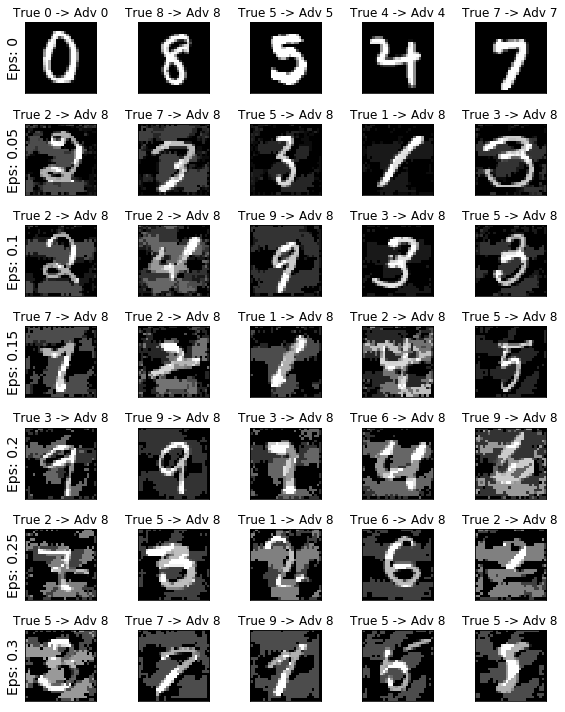

In [39]:
   # Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(8,10))

for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig, adv, ex = examples[i][j]
        plt.title("True {} -> Adv {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
        
plt.tight_layout()
plt.show()

In [0]:
def choose_100_images( model, device, test_loader, epsilon):
    chosen_images = list([] for i in range(10))
    cnt = 0
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1]
        if init_pred.item() == target.item():
            for i in range(10):
                if len(chosen_images[i])<10 and init_pred.item() != i:
                    chosen_images[i].append(data[0])
                    cnt += 1
                    break
        if cnt == 100:
            break
    return chosen_images

def attack_function( model, device, images, epsilon, selected_class):
    # Accuracy counter
    correct = 0
    adv_examples = []

    for data in images:
        data = data.unsqueeze(0).to(device)
        the_init_pred = model(data).max(1, keepdim=True)[1]
     
        num_iterations = 10
        for _ in range(num_iterations):
            data.requires_grad = True
            output = model(data)
            init_pred = output.max(1, keepdim=True)[1]
            if init_pred.item() == selected_class:
                break
            adversarial_target = torch.tensor([selected_class]).to(device)
            loss = F.nll_loss(output, adversarial_target)
            model.zero_grad()
            loss.backward()
            data_grad = data.grad.data
            data = fgsm_attack(data, epsilon, -data_grad)
            data = data.detach()

        perturbed_data = data
        output = model(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
        adv_examples.append( (the_init_pred.item(), final_pred.item(), adv_ex) )
    return adv_examples

epsilon = 0.1

images = choose_100_images( model, device, test_loader, epsilon)

adv_images = list([] for j in range(10))
for i in range(10):
    adv_images[i] = attack_function(model, device, images[i], epsilon, i)



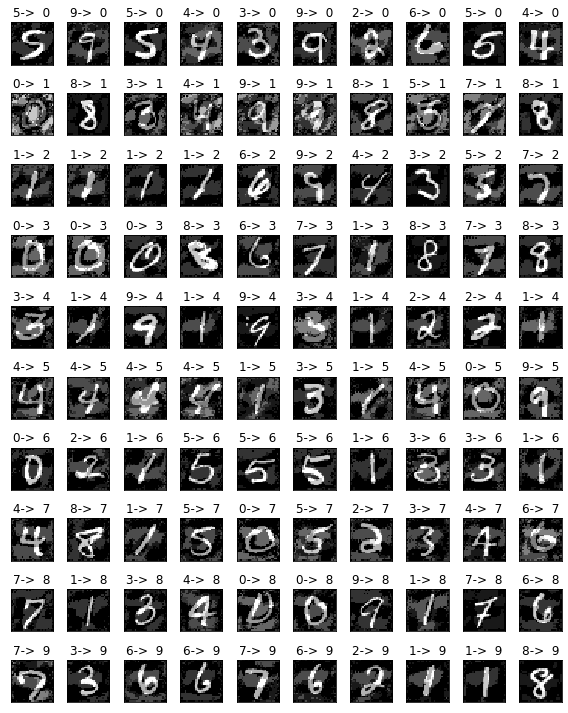

In [54]:
   # Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(8,10))

for i in range(10):
    for j in range(10):
        cnt += 1
        plt.subplot(10,10,cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        ex = adv_images[i][j][2]
        orig = adv_images[i][j][0]
        adv = adv_images[i][j][1]
        plt.title("{}->  {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()

# PRACTICUM TASK

1 - For each class select 10 images not from this class. Perform attack to move selected images to this class. for each class select image with highest confidence.
    
Best sample is the one with higher confidence.

2 - Try different epsilons for one selected class and collect the number of iterations required to achieve success

3* OPTIONAL - make attacks using a model trained on Cifar10 obtained from the previous task.